Qconfig loaded from C:\Users\ddrsq\OneDrive\Quantum\quantum_rb\Qconfig.py.
Available backends:  ['local_statevector_simulator', 'ibmqx4', 'local_unitary_simulator', 'ibmq_qasm_simulator', 'ibmqx2', 'local_clifford_simulator', 'ibmqx5', 'local_qasm_simulator']
ibmqx4
[[1, 0], [2, 0], [2, 1], [3, 2], [3, 4], [4, 2]]
2
got
here
nice
{'0000': 513, '1111': 511}


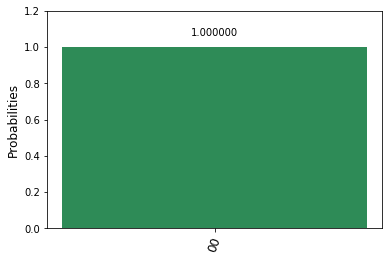

got
here
nice
{'0000': 496, '1111': 528}


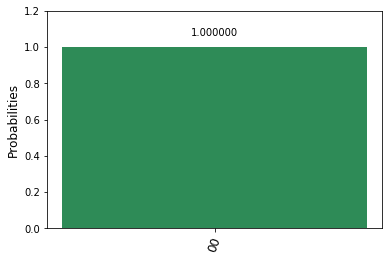

got
here
nice
{'0000': 527, '1111': 497}


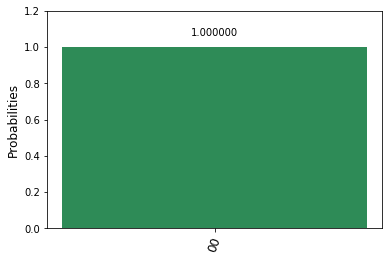

got
here
nice
{'0000': 508, '1111': 516}


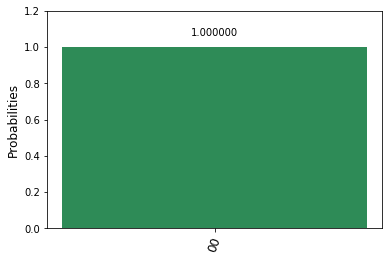

got
here
nice
{'0000': 506, '1111': 518}


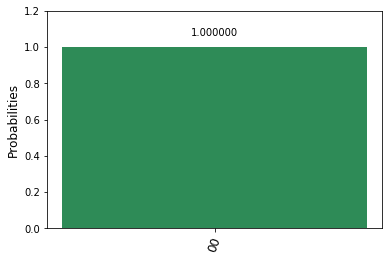

got
here
nice
{'0000': 526, '1111': 498}


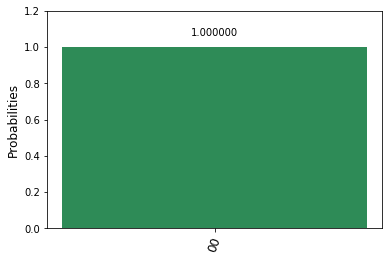

got
here
nice
{'0000': 509, '1111': 515}


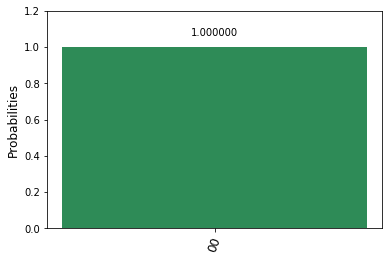

got
here
nice
{'0000': 489, '1111': 535}


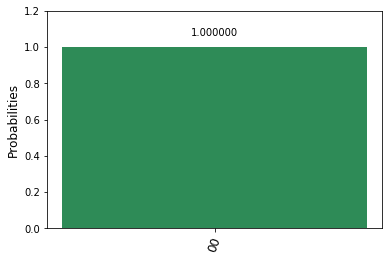

got
here
nice
{'0000': 519, '1111': 505}


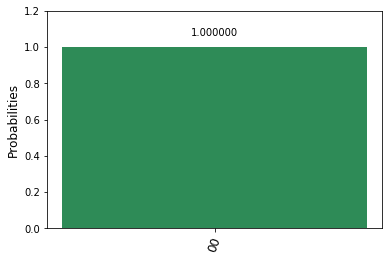

2
got
here
nice
{'0101': 509, '1010': 515}


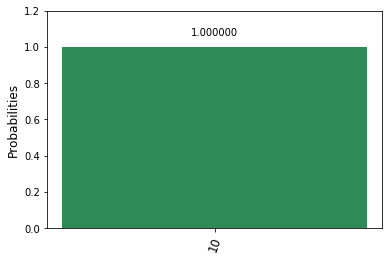

got
here
nice
{'0101': 511, '1010': 513}


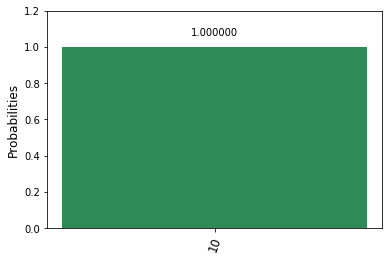

got
here
nice
{'0101': 518, '1010': 506}


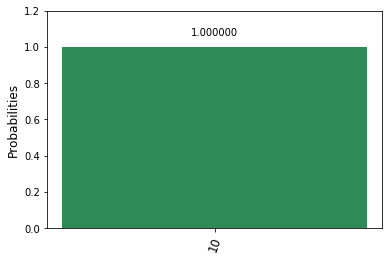

got
here
nice
{'0101': 502, '1010': 522}


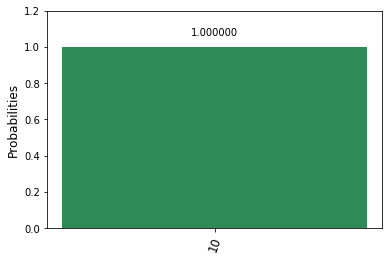

got
here
nice
{'0101': 521, '1010': 503}


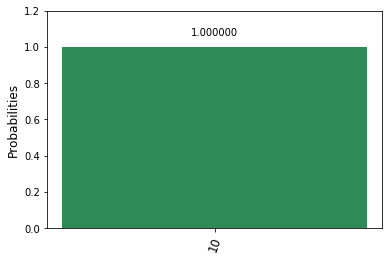

got
here
nice
{'0101': 512, '1010': 512}


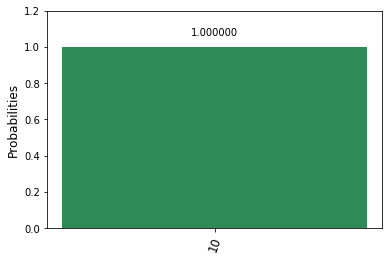

got
here
nice
{'0101': 522, '1010': 502}


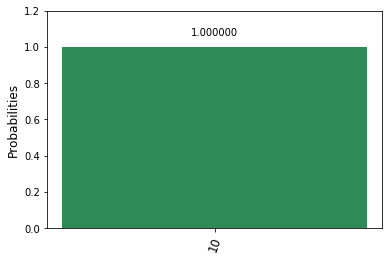

got
here
nice
{'0101': 512, '1010': 512}


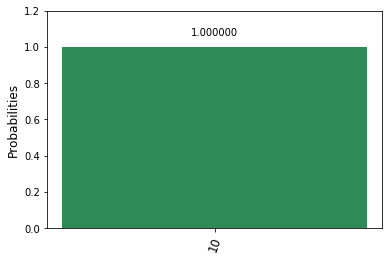

got
here
nice
{'0101': 510, '1010': 514}


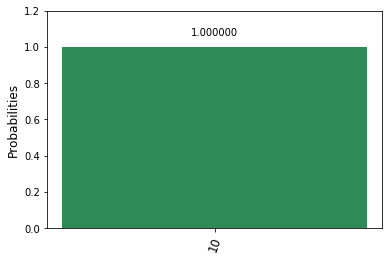

2
got
here
nice
{'0011': 521, '1100': 503}


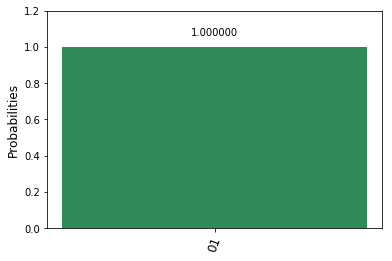

got
here
nice
{'0011': 498, '1100': 526}


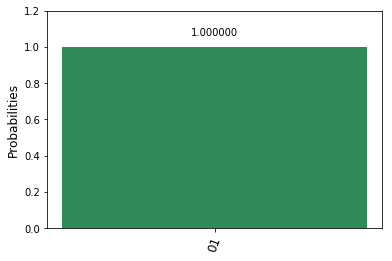

got
here
nice
{'0011': 493, '1100': 531}


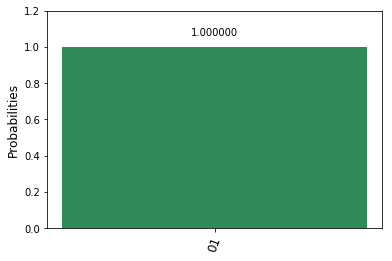

got
here
nice
{'0011': 508, '1100': 516}


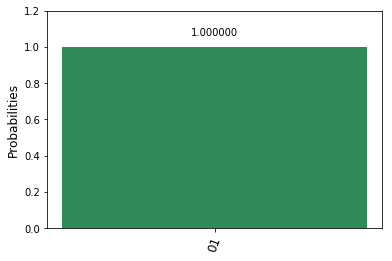

got
here
nice
{'0011': 486, '1100': 538}


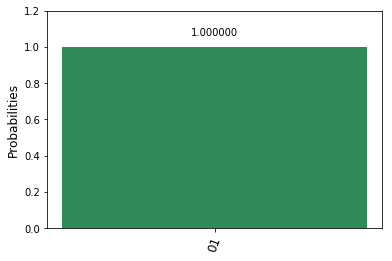

got
here
nice
{'0011': 544, '1100': 480}


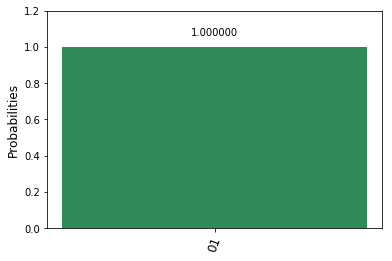

got
here
nice
{'0011': 540, '1100': 484}


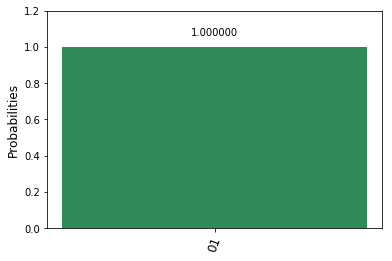

got
here
nice
{'0011': 504, '1100': 520}


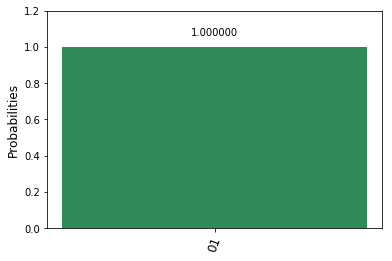

got
here
nice
{'0011': 513, '1100': 511}


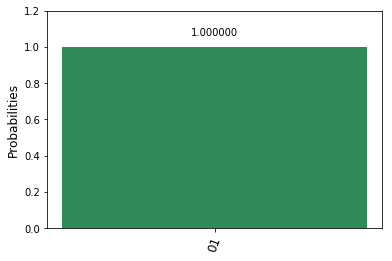

2
got
here
nice
{'0110': 496, '1001': 528}


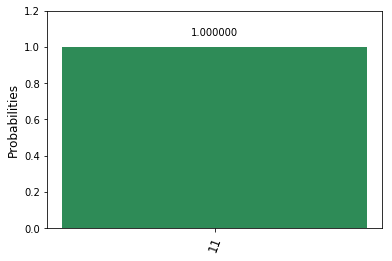

got
here
nice
{'0110': 493, '1001': 531}


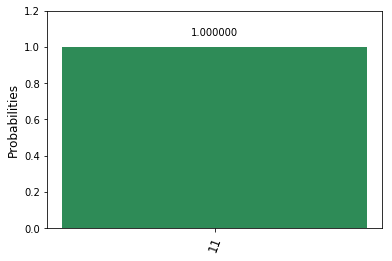

got
here
nice
{'0110': 514, '1001': 510}


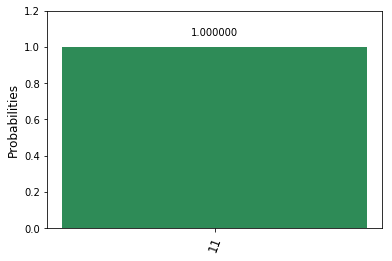

got
here
nice
{'0110': 538, '1001': 486}


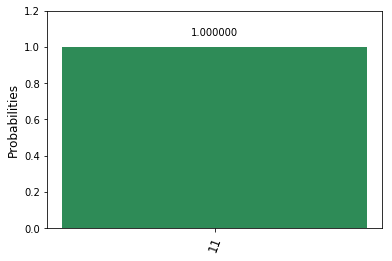

got
here
nice
{'0110': 503, '1001': 521}


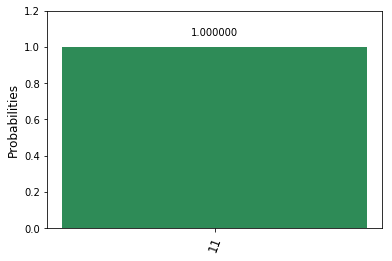

got
here
nice
{'0110': 511, '1001': 513}


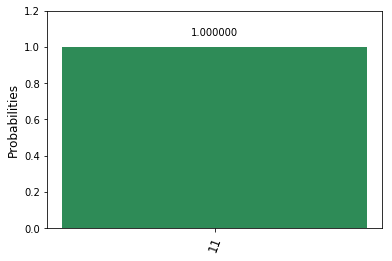

got
here
nice
{'0110': 527, '1001': 497}


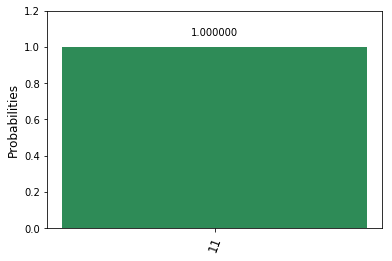

got
here
nice
{'0110': 508, '1001': 516}


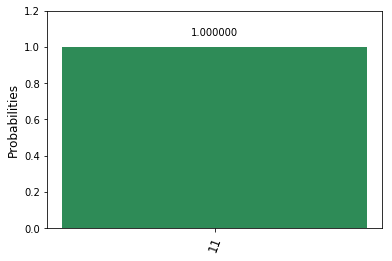

got
here
nice
{'0110': 497, '1001': 527}


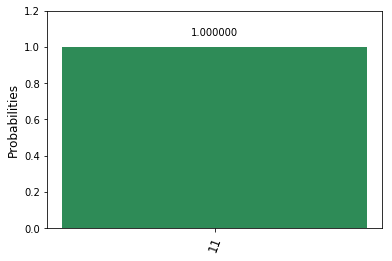

Time elapsed:  14.1399827003479


In [11]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, register, execute, get_backend
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit.tools.qi.qi import state_fidelity
import random
import pickle
import time

# helpful function
state_overlap = lambda state1, state2: np.absolute(np.dot(state1.conj().T,state2))**2

#setup
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')
    
#matlab stuff
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import matrix
from math import pi

#set api token 
QX_TOKEN = "96c86855a5c381875a4ea3a956a7deafbbbbb82e5912ec73655c7c444d2597a7364eda2fa558e4e37f672640029443216899825f945d5a0684e31b796837ce61"
QX_URL = "https://quantumexperience.ng.bluemix.net/api"


#register token and url
register(QX_TOKEN, QX_URL)


# for getting a backend
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

# query for available backends
print("Available backends: ", available_backends())

device_name = lowest_pending_jobs()
device = get_backend(device_name)
device_coupling = device.configuration['coupling_map']
print(device)
print(device_coupling)


backend = 'local_qasm_simulator'

# prepare a state of all zeros
def prepareZeros(qc):
    qc.h(qr[1])
    qc.cx(qr[1],qr[0])
    qc.cx(qr[1],qr[2])
    qc.cx(qr[2],qr[3])

    
# compile into different states
def compilation(qc,i):
        if i == 0: 
            return
        elif i == 1:
            qc.x(qr[0])
            qc.x(qr[2])
        elif i == 2:
            qc.x(qr[0])
            qc.x(qr[1])
        elif i == 3:
            qc.x(qr[2])
            qc.x(qr[1])
            
            
# parse a string of gens
def addCliffGens(qc, string):
    for char in string:
        i = int(char)
        if i==0:
            qc.x(qr[0])
            qc.x(qr[2])
        elif i==1:
            qc.x(qr[0])
            qc.x(qr[1])
        elif i==2:
            qc.z(qr[0])
            qc.z(qr[1])
        elif i==3:
            qc.z(qr[0])
            qc.z(qr[2])
        elif i ==4:
            qc.h(qr[0])
            qc.h(qr[1])
            qc.h(qr[2])
            qc.h(qr[3])
        elif i == 5:
            qc.s(qr[0])
            qc.s(qr[1])
            qc.s(qr[2])
            qc.s(qr[3])
            
        # YOU NEED TO REPLACE THIS LATER WITH CLASSICAL REINDEXING
        elif i==6:
            qc.swap(qr[0],qr[1])
        elif i==7:
            qc.swap(qr[0],qr[2])
            
# find string for generators
def findGenString(mat):
    for key, value in r2group.items():
        if np.array_equal(value, mat):
            return key
    print("OH NO")
    return None
        
# invert cliff gens 
def invertCliffGens(qc, mat):
    genString = findGenString(mat)
    for char in genString[::-1]:
        i = int(char)
        if i==0:
            qc.x(qr[0])
            qc.x(qr[2])
        elif i==1:
            qc.x(qr[0])
            qc.x(qr[1])
        elif i==2:
            qc.z(qr[0])
            qc.z(qr[1])
        elif i==3:
            qc.z(qr[0])
            qc.z(qr[2])
        elif i ==4:
            qc.h(qr[0])
            qc.h(qr[1])
            qc.h(qr[2])
            qc.h(qr[3])
        elif i == 5:
            qc.sdg(qr[0])
            qc.sdg(qr[1])
            qc.sdg(qr[2])
            qc.sdg(qr[3])
            
        # YOU NEED TO REPLACE THIS LATER WITH CLASSICAL REINDEXING
        elif i==6:
            qc.swap(qr[0],qr[1])
        elif i==7:
            qc.swap(qr[0],qr[2])

# adds random real clifford
def addRandCliff(qc, mat):
    genString = random.choice(list(r2group.keys()))
    addCliffGens(qc,genString)
    qc.barrier(qr)
    return np.matmul(mat,r2group[genString])


pickle_in = open("r2group.pickle", "rb")
r2group = pickle.load(pickle_in)


trials = 1
reps = 9
initialStates = 4
shots = 1024


startTime = time.time()

for k in range(initialStates):

    for i in range(trials):
        length = 2+3*i
        print(length)
        counts = {}

        # run our trials
        for i in range(reps):

            # run one trial of given length 
            mat = r2group[""]
            n = 4
            qr = QuantumRegister(n)
            cr = ClassicalRegister(n)
            qc = QuantumCircuit(qr, cr)
            
            # prepare encoded zeros
            prepareZeros(qc)
            
            # get the qc compiled into one of the 4 different states
            compilation(qc,k)


            # add the first m-1 clifford gates
            for i in range(length):
                mat = addRandCliff(qc,mat)

            # invert everything
            invertCliffGens(qc,mat)

            
            # measure
            qc.measure(qr,cr)        
            
            print("got")
            job = execute(qc, backend, shots = shots)
            print("here")
            result = job.result()
            print("nice")
            trial = result.get_counts(qc)
            print(trial)
            
            # clean the data
            data = {}
            for key in trial:
                ohoh = ['0000', '1111']
                ohone = ['1100', '0011']
                oneoh = ['1010', '0101']
                oneone = ['0110', '1001']
                if key not in ohoh+ohone+oneoh+oneone:
                    continue
                if key in ohoh:
                    if "00" not in data.keys():
                        data["00"] = 0
                    data["00"] += trial[key]
                elif key in ohone:
                    if "01" not in data.keys():
                        data["01"] = 0
                    data["01"] += trial[key]
                elif key in oneoh:
                    if "10" not in data.keys():
                        data["10"] = 0
                    data["10"] += trial[key]
                elif key in oneone:
                    if "11" not in data.keys():
                        data["11"] = 0
                    data["11"] += trial[key]
            plot_histogram(data)
    
endTime = time.time()
print("Time elapsed: ", endTime-startTime)



  